# Atividade 04

Aluno: Luiz Guilherme Seleme Fofano<br>
Disciplina: HIML<br>

## 1 - Importação

In [1]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV

In [2]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [3]:
Nc

850

(8192, 850)


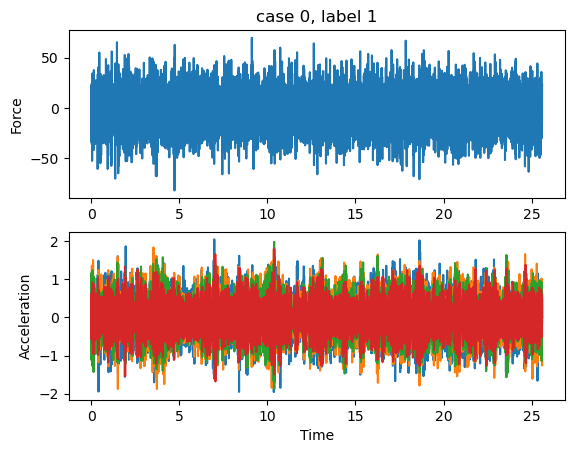

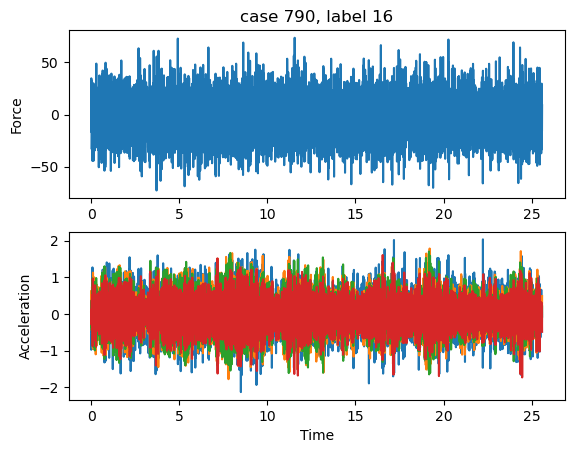

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
print(Ch1.shape)
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

## 2 - AR

In [5]:
from statsmodels.tsa.ar_model import AutoReg

In [6]:
channels = [Ch2, Ch3, Ch4, Ch5]
AR = []
order = 29 # para ficar com 30 colunas por canal (n+1)

for channel in channels:
    exp = []
    for case in range(Nc):
        reg = AutoReg(channel[:,case],lags=order).fit()
        exp.append(reg.params)
    exp = np.vstack(exp)
    AR.append(exp)

X1 = np.hstack(AR)       

In [7]:
X1.shape

(850, 120)

## 3 - Preparando os Dados

Com base na atividade 2, percebeu-se que o melhor modelo em termos de predição foi o SoftMax ajustado ao conjunto X2_sc (X2 após normalização de X1), que para este caso também será normalizado.

Dessa forma, vamos dividir o conjunto X1 normalizado entre treinamento (60%) e teste (40%), fitar o PCA apenas no conjunto de treinamento, antes de transformar o conjunto inteiro, re-normalizar os conjuntos de teste e treino pós-PCA e então fazer a busca dos hiper-parâmetros para regressão logística, SVC e KNN.

[0.37585014 0.22279748 0.10121232 0.08300921 0.05197382 0.03813015
 0.03673931 0.02504004 0.01399312 0.01232693]


São necessários 10 componentes para atingir uma variância explicada de 0.9610725174870596 (>95%)


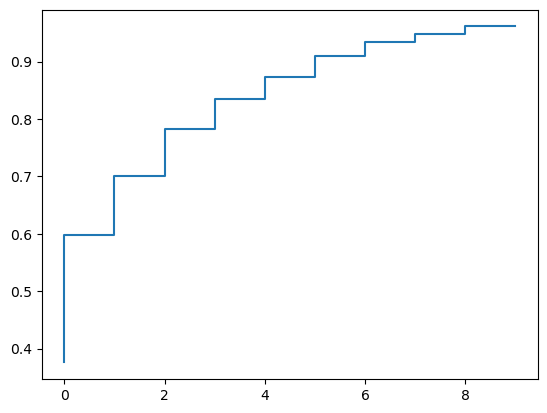

In [8]:
# Normalização
rand = 1009

scaler = MinMaxScaler(feature_range=(-1,1))
X1_sc = scaler.fit(X1).transform(X1)


# Divisão em grupo de treinamento e teste

X1_tr, X1_te, y_tr, y_te = train_test_split(X1_sc, y,random_state=rand,test_size=0.4)


# Aplicação do PCA e re-normalização

pca = PCA(n_components = 0.95)
pca.fit(X1_tr)

exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
print(exp_var)
plt.step(range(0,len(cum_var)),cum_var,label='Cumulative variance')
print(f'\n\nSão necessários {len(exp_var)} componentes para atingir uma variância explicada de {cum_var[-1]} (>95%)')

X1_tr_pca = pca.transform(X1_tr)
X1_te_pca = pca.transform(X1_te)

X1_tr_pca_norm = scaler.fit(X1_tr_pca).transform(X1_tr_pca)
X1_te_pca_norm = scaler.fit(X1_tr_pca).transform(X1_te_pca)


## 4 - Rodada com configuração default

### 4.1 - Softmax

In [9]:
y_def = []
score_def = []

logreg = LogisticRegression(multi_class='multinomial',random_state=rand,max_iter=10000).fit(X1_tr_pca_norm, y_tr)

score_train = logreg.score(X1_tr_pca_norm, y_tr)
score_test = logreg.score(X1_te_pca_norm, y_te)

print(f'Score de treino: {score_train}')
print(f'Score de teste: {score_test}')

y_def.append(logreg.predict(X1_te_pca_norm))
score_def.append(score_test)

Score de treino: 0.9901960784313726
Score de teste: 0.9823529411764705


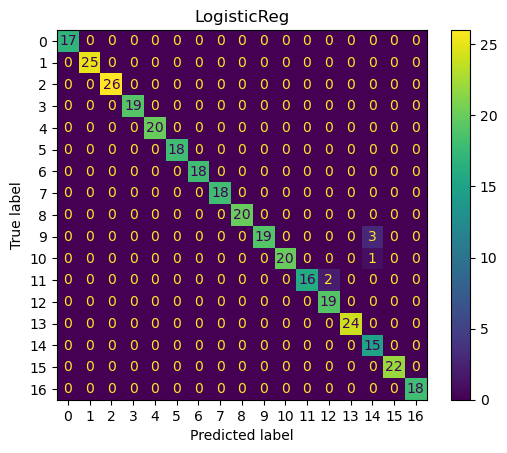

In [10]:
#plotando matriz de confusão

cm = confusion_matrix(y_te, logreg.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('LogisticReg')
cmgraph.plot(ax=ax)

### 4.2 - SVC

In [11]:
# SVC

svm = SVC(random_state=rand).fit(X1_tr_pca_norm,y_tr)
score_train = svm.score(X1_tr_pca_norm,y_tr)
score_test = svm.score(X1_te_pca_norm,y_te)

         
print(f'Score de treino: {score_train}')
print(f'Score de teste: {score_test}')

y_def.append(svm.predict(X1_te_pca_norm))
score_def.append(score_test)

Score de treino: 0.996078431372549
Score de teste: 0.9941176470588236


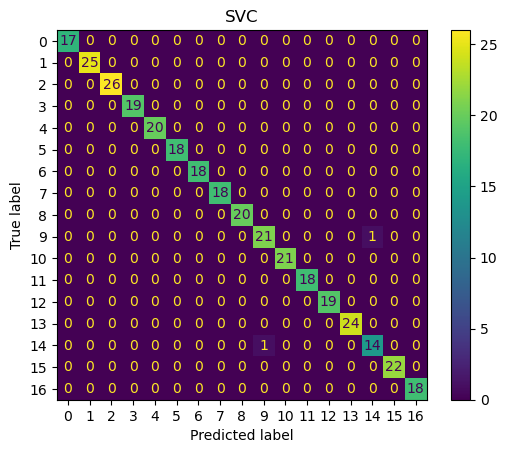

In [12]:
#plotando matriz de confusão

cm = confusion_matrix(y_te, svm.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('SVC')
cmgraph.plot(ax=ax)

### 4.3 - KNN

In [13]:
knn = KNN().fit(X1_tr_pca_norm,y_tr)
score_train = knn.score(X1_tr_pca_norm,y_tr)
score_test = knn.score(X1_te_pca_norm,y_te)

print(f'Score de treino: {score_train}')
print(f'Score de teste: {score_test}')  

y_def.append(knn.predict(X1_te_pca_norm))
score_def.append(score_test)

Score de treino: 0.9921568627450981
Score de teste: 0.9852941176470589


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


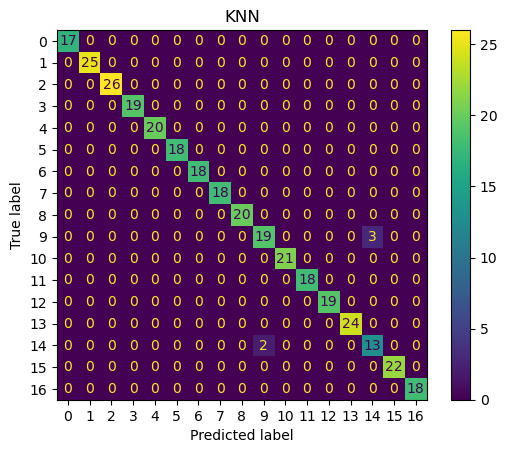

In [14]:
#plotando matriz de confusão

cm = confusion_matrix(y_te, knn.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('KNN')
cmgraph.plot(ax=ax)

## 5 -  Hyperparameter Tuning

Serão avaliados os mesmos parâmetros testados na atividade 03 para melhorar a comparação:<br><br>
**SVC** <br>
* kernel <br>
* C <br>
* degree (para o caso poly) <br><br>

**KNN** <br>
* weights <br>
* neighbors <br><br>

**LogReg** - hava considerado apenas o default, para esse caso vou avaliar <br>
* C <br>
* solver <br>


In [15]:
models = [("LogReg",LogisticRegression(multi_class='multinomial', max_iter=5000, random_state=rand)),
          ("SVC",SVC(random_state=rand)),
          ("KNN",KNN())
         ]

params = [[{"C":stats.loguniform(0.001,1000),
           "solver":['lbfgs', 'liblinear', 'newton-cg', 'sag']}],
          
          [{"kernel":["linear","poly","rbf","sigmoid"],
           "C":stats.loguniform(0.001,1000),
           "degree":[2,3,4,5]}],
          
          [{"weights":["uniform","distance"],
           "n_neighbors":stats.randint(2,100)}]
         ]

best_params = []

rkf = RepeatedKFold(n_splits=5,n_repeats=50,random_state=rand)

for k in range(len(models)):
    random_search = RandomizedSearchCV(models[k][1],verbose=0,scoring='accuracy',n_iter=100,n_jobs=-1,cv=rkf,param_distributions=params[k])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        random_search.fit(X1_tr_pca_norm,y_tr)

        yh_test = random_search.predict(X1_te_pca_norm)

        score_train = random_search.score(X1_tr_pca_norm,y_tr)
        score_test = random_search.score(X1_te_pca_norm,y_te)

        print(f'\n\n{models[k][0]}:\n')
        print(f'Score de treino: {score_train}')
        print(f'Score de teste: {score_test}')
        print('Melhor ajuste:')
        for par in random_search.best_params_.keys():
            print('        Parâmetro {}: {}'.format(par, random_search.best_params_[par]))  
        print()
        print(f'O score do ajuste Desfault foi de {score_def[k]}')
        print(f'O ganho de acurácia com o tuning foi de {score_test-score_def[k]}')
        
        best_params.append(yh_test)
        



LogReg:

Score de treino: 0.996078431372549
Score de teste: 0.9970588235294118
Melhor ajuste:
        Parâmetro C: 40.02632009624526
        Parâmetro solver: newton-cg

O score do ajuste Desfault foi de 0.9823529411764705
O ganho de acurácia com o tuning foi de 0.014705882352941235


SVC:

Score de treino: 0.9941176470588236
Score de teste: 0.9970588235294118
Melhor ajuste:
        Parâmetro C: 2.7525663030160206
        Parâmetro degree: 3
        Parâmetro kernel: linear

O score do ajuste Desfault foi de 0.9941176470588236
O ganho de acurácia com o tuning foi de 0.002941176470588225


KNN:

Score de treino: 1.0
Score de teste: 0.9941176470588236
Melhor ajuste:
        Parâmetro n_neighbors: 10
        Parâmetro weights: distance

O score do ajuste Desfault foi de 0.9852941176470589
O ganho de acurácia com o tuning foi de 0.008823529411764675


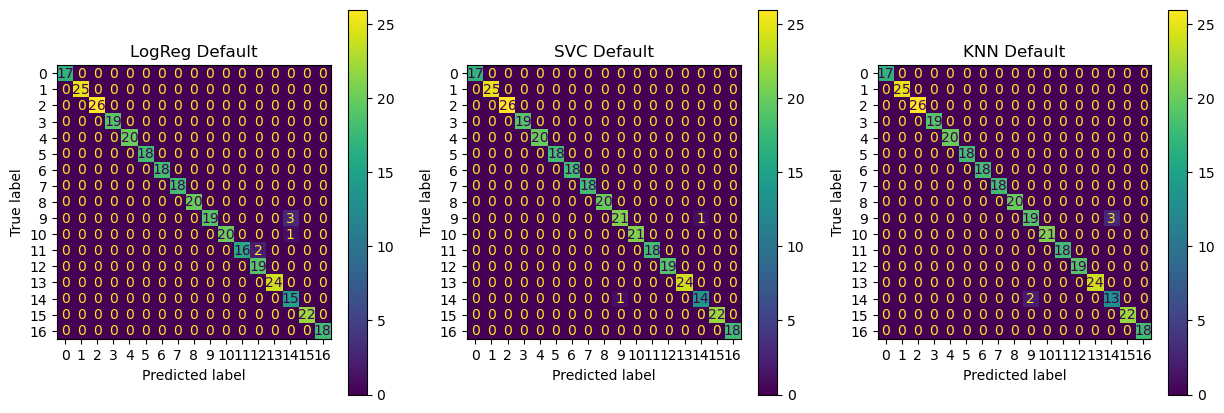

In [16]:
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=[15,5])


i = 0
for ax in axs:
    cm = confusion_matrix(y_te, y_def[i])
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(f'{models[i][0]} Default')
    cmgraph.plot(ax=ax)
    
    i = i+1


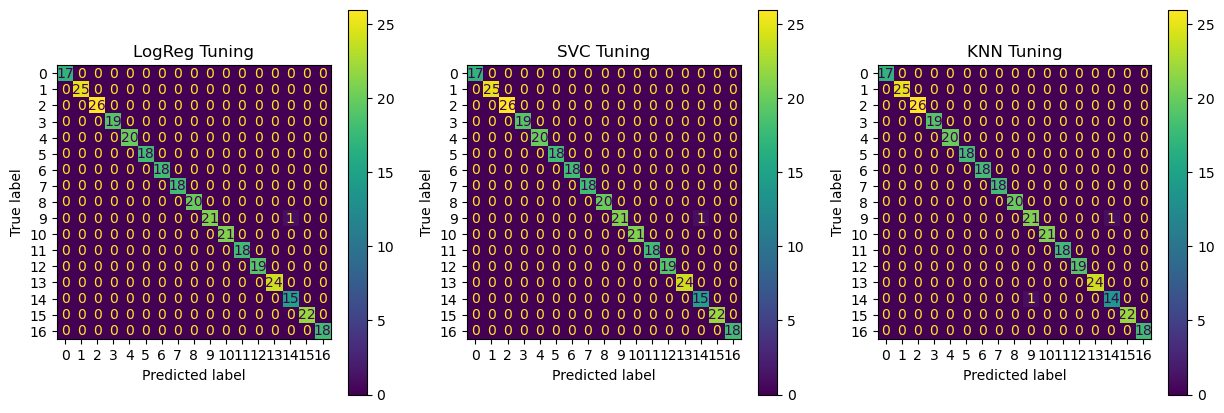

In [17]:
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=[15,5])


i = 0
for ax in axs:
    cm1 = confusion_matrix(y_te, best_params[i])
    cmgraph1 = ConfusionMatrixDisplay(cm1)
    ax.set_title(f'{models[i][0]} Tuning')
    cmgraph1.plot(ax=ax)

    
    i = i+1

## 6 - Conclusões

Pode-se perceber que a utilização do tuning de hiper-parâmetros de fato contribuiu para aumentar a acurácia dos modelos, ainda que o resultado com as configurações default já estivesse bem alto (> 0.98).<br>
Comparado com a busca manual do exercício 03, houve boa concordância entre os hiper-parâmetros otimizados, com o melhor SVC utilizando um modelo linear e C próximo de 1, enquanto o KNN otimizado usou o weights distance e numero de vizinhos na ordem de 10.